# <font style="color:blue">Train a Face Mask Detector using DarkNet YOLOv3</font>
In this notebook, a face mask detector will be trained. We will use DarkNet framework and YOLO v3 architecture.


# <font style="color:blue">Change Runtime Type</font>
Before proceeding, make sure that the notebook is running on the GPU. Go to Runtime -> Change runtime type -> Select hardware Accelerator as GPU.

# <font style="color:blue">1. Link Google Drive [ Optional ]</font>
Since it will take considerable amount of time to train the network, it is a good idea to link your Google Drive with Colab so that everything is backed up. So, if the runtime gets disconnected in the middle of something, you can simply re-link the drive and start working. To link drive, just run the cell below and follow the 2 steps.

1. It will generate a link. Click on the link to login to your google account
1. Get the authorization code and paste it in the box under the cell.

You may however choose to do everything without linking google drive and everything will work as usual.

### <font style="color:green">Uncomment the 2 cells below to link google drive</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/darknet

/content/drive/My Drive/darknet


# <font style="color:blue">2. Clone the DarkNet Repository </font>
We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

# <font style="color:blue">3. Compile DarkNet</font>
We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [ ]:
!pwd


/content/drive/My Drive/darknet


In [ ]:
%cd darknet

[Errno 20] Not a directory: 'darknet'
/content/drive/My Drive/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

/content/drive/My Drive/darknet
Building. . . It might take 2 minutes
Build completed.


## <font style="color:blue">4.1. Download Data</font>


In [ ]:
!wget "https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip?dl=1" -O mask-data.zip
!unzip mask-data.zip &> /dev/null

--2021-01-17 03:14:28--  https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip [following]
--2021-01-17 03:14:29--  https://www.dropbox.com/s/dl/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3c4143ad3ccee1913ba59d2b5b.dl.dropboxusercontent.com/cd/0/get/BHKp0PgNqAY5UL5zzFowlDorhRlCUX8MGRQfgTuxuurkfmOMTRhYjOJIIgy22t-d2H6pzHS9AfwXSl4fnXOmBEnIHMfAHMZObEbkGBw0jRQ9QXVEvGv_u8KnvN00vODR9x0/file?dl=1# [following]
--2021-01-17 03:14:29--  https://uc3c4143ad3ccee1913ba59d2b5b.dl.dropboxusercontent.com/cd/0/get/BHKp0PgNqAY5UL5zzFowlDorhRlCUX8MGRQfgTuxuurkfmOMTRhYjOJ

## <font style="color:blue">4.2. Prepare dataset files</font>
We need to create a txt file which contains the path to the images. These files will be used while setting up the training. 

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [ ]:
%pwd


'/content/drive/My Drive/darknet'

In [ ]:
import random
import os
import subprocess
import sys

image_dir = "./mask-data"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg" or f.split(".")[-1] == "jpeg" or f.split(".")[-1] == "png"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

# <font style="color:blue">5. Download weights for Convolutional backbone</font>
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone. 

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [ ]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2020-04-01 19:05:53--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2020-04-01 19:05:53--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc723ca5296692b6a6d2bd6ef13f.dl.dropboxusercontent.com/cd/0/get/A1CSI25YA5X2Ga9La1eUh-dm4Gtd7lQ-F2ryeEk_X1WHaIVX8n6j7ljUAiElhOVoB7nu7AdDs8Xh7hUX_wr9Gd2IurcOM-65xIL7ZC-fxMFX0MwX91gf7episSF1g08XuTA/file?dl=1# [following]
--2020-04-01 19:05:54--  https://uc723ca5296692b6a6d2bd6ef13f.dl.dropboxusercontent.com/cd/0/get/A1CSI25YA5X2Ga9La1eUh-dm4Gtd7lQ-F2ryeEk_X1WHaIVX8n6j7ljUAiElhOVoB7nu7AdDs8Xh7hUX_wr9Gd2IurcOM-

# <font style="color:blue">6. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file, 
1. path to config file, 
1. path to convolutional weights file 

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [3]:
!chmod 777 darknet

In [4]:
!./darknet detector train yolov3-mask-setup.data yolov3-mask-train.cfg backup/darknet53.conv.74 -dont_show -map -clear 2> train_log.txt

Streaming output truncated to the last 5000 lines.
 Last accuracy mAP@0.5 = 81.35 %, best = 83.66 % 
 1131: 1.837182, 1.454486 avg loss, 0.001000 rate, 4.055350 seconds, 72384 images, 2.152494 hours left
Loaded: 0.000051 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 81.35 %, best = 83.66 % 
 1132: 2.658430, 1.574881 avg loss, 0.001000 rate, 4.052032 seconds, 72448 images, 2.140759 hours left
Loaded: 0.000062 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 81.35 %, best = 83.66 % 
 1133: 3.738426, 1.791235 avg loss, 0.001000 rate, 4.172608 seconds, 72512 images, 2.129121 hours left
Loaded: 0.000048 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 81.35 %, best = 83.66 % 
 1134: 1.720999, 1.784212 avg loss, 0.001000 rate, 4.145850 seconds, 72576 images, 2.117879 hours left
Loaded: 0.000045 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 81.35 %, best = 83.66 % 
 1135: 

# <font style="color:blue">Notes on Training</font>
From the above training process we can make the following observations:
1. The images are resized after every 10 iterations
It takes around 11 seconds per iteration which consists of 64 images for an image size of 576.
1. We can see that the training started very slowly in the first few iterations and then very gradually, the loss started reducing.
1. As we can see the learning rate increases gradually from 0 to 0.001 by the 100th batch ( burn_in was set to 100 ). It would stay there till the 1500th batch when it would again change to 0.0001.
1. mAP is calculated for every 100 iterations. It reaches >80% after 200 iterations.
1. You can check out the training graph for mAP v/s iterations which is saved in the file **chart.png**

# <font style="color:blue">7. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

We have written a simple utility function which can be used to display the input and output similar to what we did in the previous section

We are already familiar with the inference code which we saw in the previous section.

In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

### <font style="color:green">7.1. Test Image 1</font>

In [ ]:
!wget "https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1" -O test1.jpg

--2021-01-17 19:34:53--  https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/fxei8rit9v2n83s/test-image1.jpg [following]
--2021-01-17 19:34:53--  https://www.dropbox.com/s/dl/fxei8rit9v2n83s/test-image1.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6a5eeea7de1b572096ac336b6f.dl.dropboxusercontent.com/cd/0/get/BHP0xSzxA_SO2RhUr8FEMPZs2StD9L7X1qi5EoCFOYfVvtxyfYbSKmioB5EVkU5FgIt-6zITpMe8HiTvMaXv5ev3SIkfcdcTdU9kkdy0pWd3ulL7i8h6xgwzGvNMLrZ8b1U/file?dl=1# [following]
--2021-01-17 19:34:53--  https://uc6a5eeea7de1b572096ac336b6f.dl.dropboxusercontent.com/cd/0/get/BHP0xSzxA_SO2RhUr8FEMPZs2StD9L7X1qi5EoCFOYfVvtxyfYbSKmioB5EVkU5FgIt-6zITpMe8HiTvMaXv5ev3SIkfcdcTd

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 121 K-images (1 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test1.jpg: Predicted in 46.111000 milli-seconds.
Mask: 100%


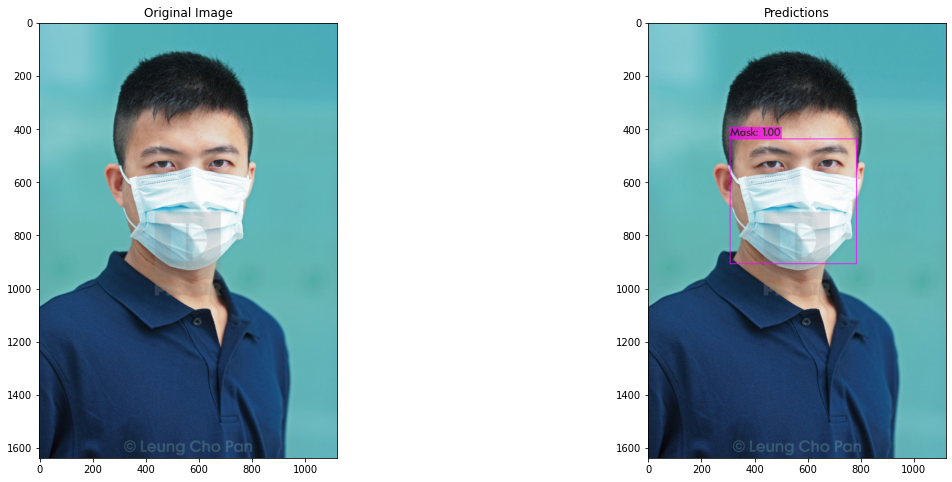

In [25]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test1.jpg -thresh .6 2> /dev/null
display_output("test1.jpg")

### <font style="color:green">7.2. Test Image 2</font>

In [10]:
!wget https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1 -O test2.jpg

--2021-01-24 04:25:18--  https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ia1fijzr69ytpp1/test-image2.jpg [following]
--2021-01-24 04:25:18--  https://www.dropbox.com/s/dl/ia1fijzr69ytpp1/test-image2.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44145cf7293cda0d8199291017.dl.dropboxusercontent.com/cd/0/get/BHmCVNj1MKzsAdX91nged4HCjWb9WbC4Bx21XE3sbD2SZLvaQ2a49-4J5tFaLO01F7MrVacYRRN7PC97dFgEOnYW9XBcvK8JC6Eg62vyUN38Gq_tXZMmD1Fq1z_Z-qNXwbM/file?dl=1# [following]
--2021-01-24 04:25:18--  https://uc44145cf7293cda0d8199291017.dl.dropboxusercontent.com/cd/0/get/BHmCVNj1MKzsAdX91nged4HCjWb9WbC4Bx21XE3sbD2SZLvaQ2a49-4J5tFaLO01F7MrVacYRRN7PC97dFgEOnYW9XBcvK8JC6Eg

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 121 K-images (1 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test2.jpg: Predicted in 46.124000 milli-seconds.
Mask: 100%
Mask: 100%
Mask: 87%
No-mask: 100%
Mask: 84%


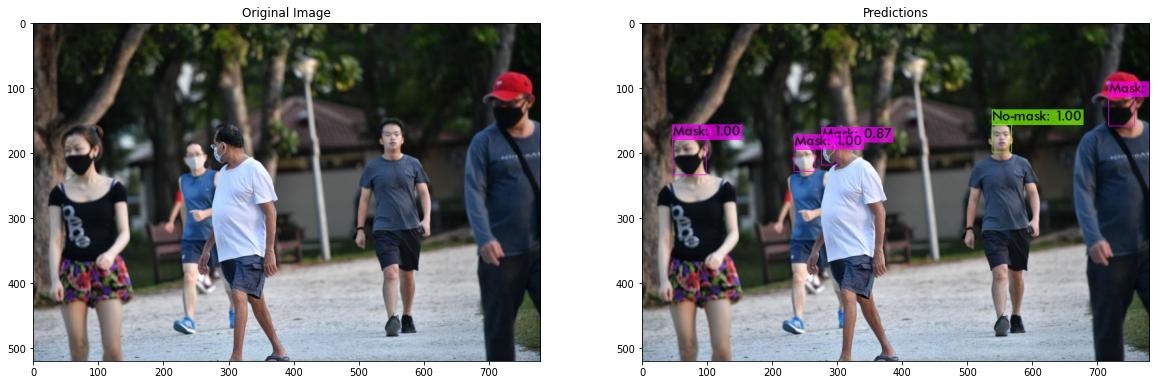

In [26]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test2.jpg -thresh .6 2> /dev/null
display_output("test2.jpg")

### <font style="color:green">7.3. Test Image 3</font>

In [12]:
!wget https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1 -O test3.jpg

--2021-01-24 04:26:40--  https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/g905k4r1git5kbx/test-image3.jpg [following]
--2021-01-24 04:26:41--  https://www.dropbox.com/s/dl/g905k4r1git5kbx/test-image3.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1c57abd4bb73a09836252f7ea7.dl.dropboxusercontent.com/cd/0/get/BHmxlTTaKMv58oPslT80LvMBmxTsxL2Y0aSbVeHrwaU4MnvbLFoe1TSUve80OL8KZlrovZbHc-o6krZgx9kWrw6UUR3DFNA01KReeAwQnNogyG9kzyG6Dtx3VPZcYKadRNQ/file?dl=1# [following]
--2021-01-24 04:26:42--  https://uc1c57abd4bb73a09836252f7ea7.dl.dropboxusercontent.com/cd/0/get/BHmxlTTaKMv58oPslT80LvMBmxTsxL2Y0aSbVeHrwaU4MnvbLFoe1TSUve80OL8KZlrovZbHc-o6krZgx9kWrw6UUR3DFNA01K

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 121 K-images (1 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test3.jpg: Predicted in 46.075000 milli-seconds.
Mask: 100%
Mask: 98%
Mask: 100%
No-mask: 98%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 99%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 99%
Mask: 100%
Mask: 100%


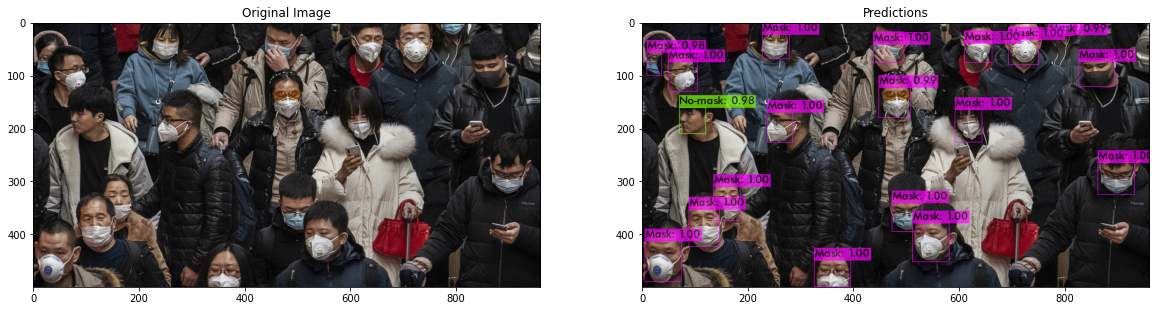

In [27]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test3.jpg -thresh .6 2> /dev/null
display_output("test3.jpg")

### <font style="color:green">7.4. Test Image 4</font>

In [14]:
!wget https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1 -O test4.jpg

--2021-01-24 04:27:52--  https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/90ggmiur7b8g35m/test-image4.jpg [following]
--2021-01-24 04:27:52--  https://www.dropbox.com/s/dl/90ggmiur7b8g35m/test-image4.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2057c6033e5ba2e5a1d897a79c.dl.dropboxusercontent.com/cd/0/get/BHni_o1ucL8s6hirCVRPGd58k6jGAwd6UQW8R1kRogspRt4w6v1nXrAwPudoFWobxFnbkif27T8n3_SRGbAlRChxklcjlnBKNIxS9AQodKJEnEyCZaS3yfHvjjkocNYxR1Q/file?dl=1# [following]
--2021-01-24 04:27:52--  https://uc2057c6033e5ba2e5a1d897a79c.dl.dropboxusercontent.com/cd/0/get/BHni_o1ucL8s6hirCVRPGd58k6jGAwd6UQW8R1kRogspRt4w6v1nXrAwPudoFWobxFnbkif27T8n3_SRGbAlRChxklcjlnBKNIxS

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 121 K-images (1 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test4.jpg: Predicted in 46.150000 milli-seconds.
No-mask: 99%
No-mask: 52%
Mask: 100%
Mask: 100%
No-mask: 97%
Mask: 100%
No-mask: 90%
Mask: 100%


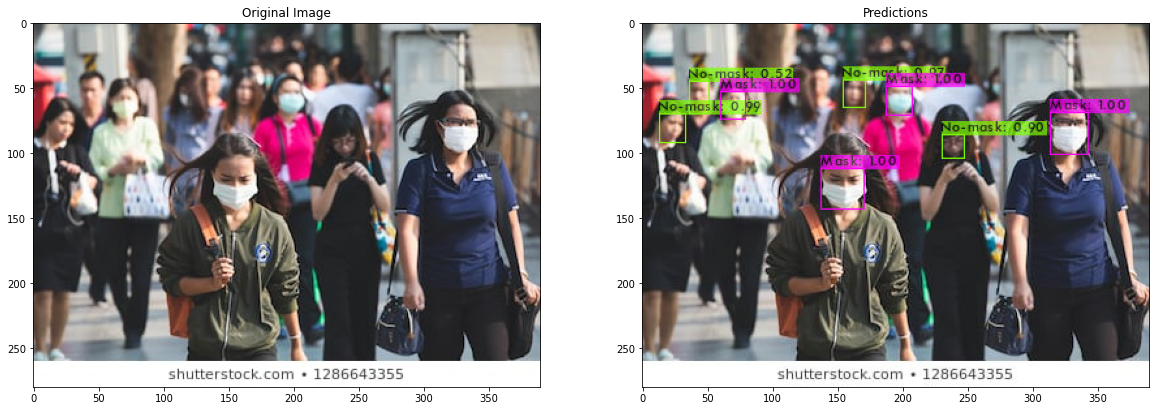

In [31]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test4.jpg -thresh .4 2> /dev/null
display_output("test4.jpg")

### <font style="color:green">7.5. Test Video 1</font>

In [32]:
!wget https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1 -O test-video1.mp4
!./darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test-video1.mp4 -thresh .9 -out_filename out-vid1.avi -dont_show 2> /dev/null

Streaming output truncated to the last 5000 lines.

FPS:35.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 99% 
Mask: 98% 
Mask: 96% 

FPS:35.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 99% 
Mask: 98% 
Mask: 98% 

FPS:34.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 100% 
Mask: 99% 
Mask: 98% 
Mask: 97% 

FPS:34.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 98% 
Mask: 99% 
Mask: 97% 
Mask: 97% 

FPS:34.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 98% 

FPS:35.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 99% 
Mask: 100% 
Mask: 99% 
Mask: 99% 
Mask: 99% 

FPS:35.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-mask: 91% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:35.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 99% 
Mask: 93% 

FPS:36.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100%

### <font style="color:green">7.6. Test Video 2</font>

In [33]:
!wget https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1 -O test-video2.mp4
!./darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test-video2.mp4 -thresh .6 -out_filename out-vid2.avi -dont_show 2> /dev/null

Streaming output truncated to the last 5000 lines.
No-mask: 95% 
No-mask: 91% 
No-mask: 86% 
No-mask: 76% 
No-mask: 61% 

FPS:30.9 	 AVG_FPS:34.0

 cvWriteFrame 
Objects:

No-mask: 94% 
No-mask: 90% 
No-mask: 87% 
No-mask: 83% 

FPS:30.8 	 AVG_FPS:34.0

 cvWriteFrame 
Objects:

No-mask: 97% 
No-mask: 94% 
No-mask: 93% 
No-mask: 90% 
No-mask: 69% 

FPS:31.0 	 AVG_FPS:34.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 95% 
No-mask: 82% 
No-mask: 71% 
Mask: 88% 

FPS:31.3 	 AVG_FPS:34.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 94% 
No-mask: 83% 
No-mask: 72% 
Mask: 86% 

FPS:31.6 	 AVG_FPS:34.0

 cvWriteFrame 
Objects:

No-mask: 99% 
No-mask: 99% 
No-mask: 93% 
No-mask: 75% 
Mask: 93% 

FPS:31.3 	 AVG_FPS:34.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 95% 
No-mask: 95% 
No-mask: 83% 
Mask: 77% 

FPS:30.8 	 AVG_FPS:34.0

 cvWriteFrame 
Objects:

No-mask: 100% 
No-mask: 99% 
No-mask: 95% 
No-mask: 83% 
No-mask: 75% 

FPS:30.6 	 AVG_FPS:34.0

 cvWriteFrame 
Objects:

No-